# Project 1 - Andrew Eden

The goal of my project will be to predict the mana cost of Magic The Gathering cards based off of their characteristics. Magic The Gathering is a popular trading card game released in 1993 with over 20,000 cards printed. Each card has a known cost, therefore, we will be able to train our prediction with respect to this known value. For simplicity, we will be using the converted mana cost, which is simply the overall cost without considering any color restrictions. The rest of our features will hopefully provide insight into the evolution of this mana cost, and will include characteristics such as card type and card text. 

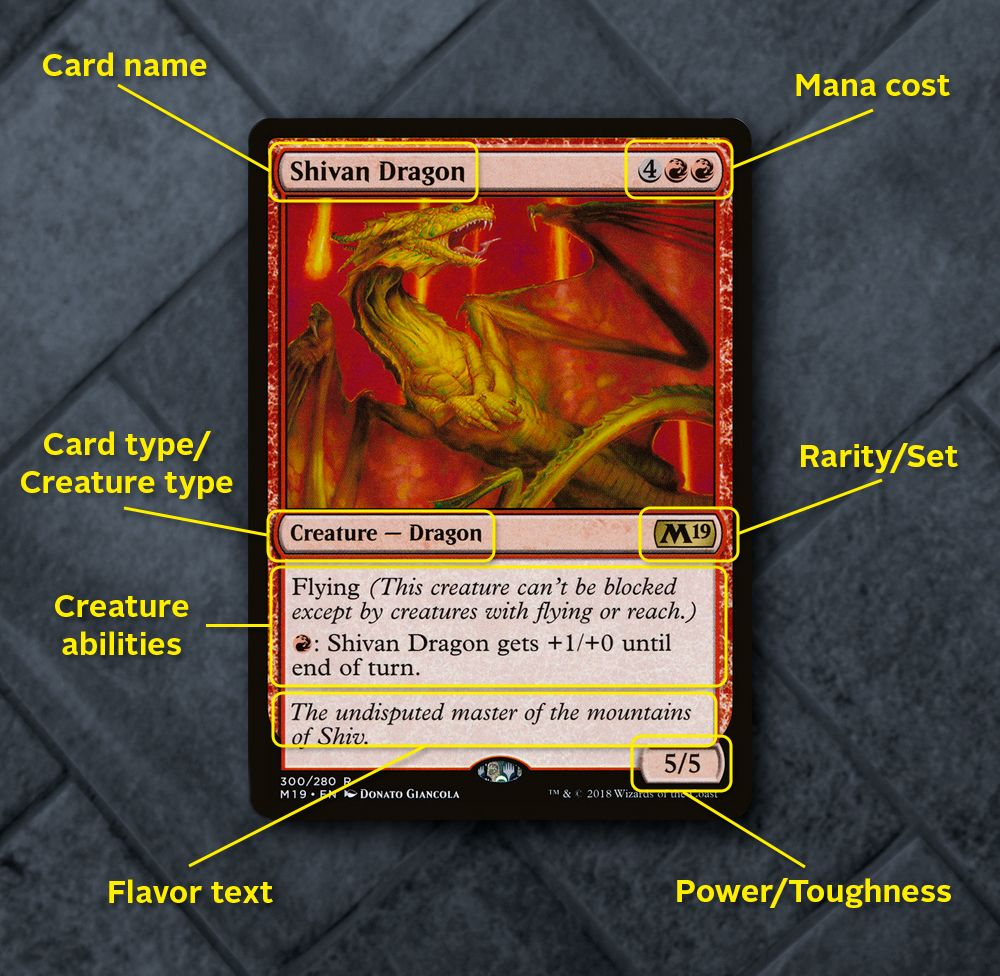

## Data Preparation

The data we are using is bulk data for individual Magic the Gathering cards throughout history. To access this data, we have locally downloaded a bulk data file in json formatting from `https://scryfall.com/docs/api/bulk-data`. The particular dataset we will be using is the `Oracle Cards` dataset, which contains the latest version of each card, thus preventing duplicate cards. Furthermore, this data is conveniently stored in a JSON file, and uncompressed only amounts to `126 MB`. This data size is aided by the fact that we will only be processing text data, and therefore we do not need to download any image files. We can begin accessing the data by simply parsing through the JSON file using built-in python tools.

In [116]:
import json

# Open and read local json
path = 'oracle-cards-20231009090140.json'
with open(path, 'r') as json_file:
    data = json.load(json_file)

Let's clean the data a bit to make our lives easier. To do so we will remove the following cards:
* **Non-normal layouts:** this includes cards like adventures and double-faced cards, which are essentially two cards in one. These may skew the data, so we will ignore them.
* **Universes Beyond cards:** these are collaborative cards with other IPs (e.g. Warhammer, Lord of the Rings). These cards often add mechanics with unique keywords for cards.
* **Un-sets:** these are joke sets and often have very wacky mechanics. 
* **Online sets:** these are sets that are only available online, and often feature inpracticle mechanics. 
* **Tokens:** these are game pieces that are introduced through other cards, and are not playable on their own. 

In [117]:
# Specify the sets to be removed
specified_sets = ["40k", "who", "clb", "afr", "fj22", "fltr"] 
specified_set_type = ["funny", "memorabilia"]

# Filter out cards from the data
data = [
    card_data for card_data in data 
    if 'normal' in card_data.get('layout', [])                   # remove problematic layouts
    and 'paper' in card_data.get('games', [])                    # remove non-paper cards (ie. online cards)
    and card_data.get('layout', '') != 'token'                   # remove tokens
    and card_data.get('set', '') not in specified_sets           # remove problematic sets
    and card_data.get('set_type', '') not in specified_set_type  # remove problematic set types
]

Now we can extract the data we want to use for each card by specifying which parameter we want from the json file. The parameters we want to extract will be listed below, along with their encoding method:
* **converted mana cost (cmc):** this is a simplified version of the mana cost, which uses a single float value to represent the mana value without taking into account the card color or additional symbols
* **printed date:** this is the date the card was printed, and we simply need to extact the year for the date string and ensure it is in integer form
* **set:** we will be using label encording, which reduces dimensionality compared to one-hot encoding while assigning a unique integer label to each set. We will need to be cautious as it may add unintended ordinal relationships in our data
* **oracle text:** this is a block of text, which we will be using Word2Vec to encode after training on gensim

Additionally, it is important to note we will also be extracting additional data such as **keywords** and **card name**, but these are either redundant or will not provide much indication regarding the mana cost, therefore, they will be omitted from our model and are simply used as sanity checks. 

First let's make sure we have the appropriate nltk package for tokenizing the oracle text.

In [118]:
import nltk

# Download punkt for nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/andreweden/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

Next we can extract all the necessary data from the json file.

In [279]:
from sklearn.preprocessing import LabelEncoder
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
import numpy as np

# Initialize lists for ordered and possibly duplicated characteristics
card_list = []
all_oracle_text = []
all_cmc = []

# Initialize sets for unordered and not duplicatable characteristics
unique_keywords = set()
unique_set_names = set()
unique_card_types = set()
unique_cmc = set()

# Iterate through the JSON data to extract card information and collect unique set names, keywords, and oracle text
for card_data in data:
    card_info = {
        'name': card_data.get('name', ''),                          # debugging
        'oracle_text': card_data.get('oracle_text', ''),            # extact each card's oracle text
        'keywords': card_data.get('keywords', []),                  # debugging
        'cmc': card_data.get('cmc', 0),                             # extract the converted mana value as a float
        'printed_date': int(card_data.get('released_at', '')[:4]),  # extract the year as an integer
        'set': card_data.get('set', ''),                            # extract the card set before encoding
        'type': card_data.get('type_line', []).split(" — ")[0],     # extract the main card type
    }
    
    # Update lists and sets
    unique_keywords.update(card_info['keywords'])
    unique_set_names.update([card_info['set']])
    all_oracle_text.append(card_info['oracle_text'])
    unique_card_types.update([card_info['type']])
    unique_cmc.update([card_info['cmc']])
    all_cmc.append([card_info['cmc']])

    # Update the card information list
    card_list.append(card_info)

Let's make sure all the stored values look correct. 

In [280]:
print(unique_cmc)
print(len(unique_cmc))

{0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0}
17


Converted mana costs look good, all being whole values ranging from 0 to 16. Let's also find the mean value of the cmc. For this we created a seperate `all_cmc` array which will store each cmc instead of the unique ones. By converting this to a numpy array we can easily find the mean value.

In [281]:
all_cmc = np.array(all_cmc)
print(np.mean(all_cmc))

3.2840699411299537


Alright, now we know moving forward that the mean value is approximately 3, which may be usefull when evaluating our model.

In [121]:
print(unique_card_types)
print(len(unique_card_types))

{'Tribal Enchantment', 'Land', 'Legendary Planeswalker', 'Sorcery', 'Legendary Creature', 'Tribal Sorcery', 'Snow Artifact Creature', 'Enchantment Creature', 'Snow Instant', 'Legendary Enchantment Creature', 'Dungeon', 'Land Creature', 'Legendary Artifact', 'World Enchantment', 'Snow Artifact', 'Instant', 'Legendary Enchantment', 'Legendary Artifact Creature', 'Conspiracy', 'Creature', 'Legendary Snow Land', 'Basic Land', 'Card', 'Tribal Instant', 'Snow Land', 'Enchantment', 'Legendary Snow Enchantment', 'Legendary Sorcery', 'Basic Snow Land', 'Snow Creature', 'Token Artifact Creature', 'Legendary Land', 'Legendary Instant', 'Snow Enchantment', 'Artifact Land', 'Artifact Creature', 'Artifact', 'Legendary Snow Creature', 'Tribal Artifact', 'Snow Sorcery', 'Legendary Enchantment Artifact'}
41


In [122]:
print(unique_keywords)
print(len(unique_keywords))

{'Riot', 'Ninjutsu', 'Living weapon', 'Delirium', 'Kinship', 'Melee', 'Celebration', 'Wither', 'Fateseal', 'Undergrowth', 'Cycling', 'Haste', 'Aura Swap', 'Unleash', 'Annihilator', 'Partner', 'Food', 'Imprint', 'Join forces', 'Heroic', 'Suspend', 'Threshold', 'Trample', 'Encore', 'Protection', 'Mountaincycling', 'Overload', 'Enchant', 'Treasure', 'Connive', 'Cleave', 'Fabricate', 'Cipher', 'Dredge', 'Mountainwalk', 'Support', 'Split second', 'Defender', 'Reinforce', 'Legendary landwalk', 'Miracle', 'Myriad', 'Coven', 'Training', 'Rally', 'Banding', 'Ascend', 'Spell mastery', 'Awaken', 'Dethrone', 'Intimidate', 'Rampage', 'Recover', 'Landfall', 'Fateful hour', 'Convoke', 'Devoid', 'Outlast', 'Islandcycling', 'Unearth', 'Totem armor', 'Changeling', 'Bargain', 'Extort', 'Entwine', 'Reach', 'Buyback', 'Surge', 'Metalcraft', 'Battle Cry', 'Replicate', 'Devour', 'Flash', 'Delve', 'Renown', 'Alliance', 'Will of the council', 'Exert', 'Lifelink', 'Bestow', 'Typecycling', 'Mentor', 'Clash', 'Ba

In [123]:
print(unique_set_names)
print(len(unique_set_names))

{'ddg', 'hop', 'ody', 'c21', 'scg', 'p02', 'isd', 'ktk', 'tund', 'khm', 'mma', 'afc', 'por', '2x2', 'mmq', 'c20', 'fut', 'brc', 'gn3', 'ddu', 'inv', 'bfz', 'ltc', 'tbth', '5dn', 'ddn', 'smom', 'tfth', 'ddk', 'gn2', 'm10', 'onc', 'tafr', 'm12', 'leg', 'ddj', 'gnt', 'ddo', 'woc', 'cns', 'evg', 'sok', 'mh2', '9ed', 'ddf', '4ed', 'tor', 'rna', 'dtk', 'war', 'aer', 'm14', 'tmp', 'thb', 'tsr', 'akh', 'usg', 'mbs', '5ed', 'gvl', 'plc', 'bbd', 'tone', 'ptk', 'ema', 'ogw', 'c16', 'ons', 'gs1', 'znc', 'arb', 'jud', 'dds', 'a25', 'stx', 'cmr', 'arc', 'cmm', 'moc', 'ala', 'lrw', 'mic', 'cn2', 'sum', 'mm3', 'csp', 'ddi', 'wth', 'dmc', 'sld', 'ulg', 'mrd', 'jvc', '2ed', 'snc', 'dom', 'm11', 'rex', 'mm2', 'ice', 'atq', 'apc', 'zen', 'c17', 'lci', 's99', 'som', 'ddt', 'm21', 'ori', 'dde', 'dvd', 'ncc', 'w16', 'frf', 'nph', 'c18', 'gtc', 'voc', 'bng', 'one', 's00', 'eld', 'bro', '10e', 'dka', 'dis', 'pcy', 'khc', 'ddq', 'tunf', 'e01', 'nem', '2xm', 'rtr', 'uds', 'ddr', 'mid', '8ed', 'grn', 'mom', 'jou'

All the other extracted values also look good, with a decent variety of values. If we really wanted to, we could split the card types so that concatinated types such as `Legendary Creature` are seperated into `Legendary` and `Creature`, however, with so few values we can leave it as is for simplicity. 

At this point we've extracted the data we need from the json file, and we can begin encoding as necessary. 

First let's encode the set using label encoding. 

In [125]:
# Initialize LabelEncoder and fit it on all unique set names
set_encoder = LabelEncoder()
set_encoder.fit(list(unique_set_names));

# Add the encoded values
for card_info in card_list:
    card_info['encoded_set'] = set_encoder.transform([card_info['set']])[0]

Let's check how many unique Magic the Gathering sets we encoded and stored. 

In [126]:
# Get the labels assigned to sets by the LabelEncoder
set_labels = set_encoder.transform([card_info['set'] for card_info in card_list])

# Count the number of unique sets
num_unique_sets = len(set(set_labels))

print(f"Number of unique sets: {num_unique_sets}")

Number of unique sets: 217


Next let's encode the oracle text using Word2Vec. This requires that we train our our vectorization model based on tokenized data. 

In [127]:
# Train a Word2Vec model on oracle text
tokenized_oracle_text = [word_tokenize(text.lower()) for text in all_oracle_text]
model = Word2Vec(sentences=tokenized_oracle_text, vector_size=100, window=5, min_count=1, sg=0)

# Encode the oracle text
def encode_text(text, model):
    words = word_tokenize(text.lower())
    word_vectors = [model.wv[word] for word in words if word in model.wv]
    if word_vectors:
        return sum(word_vectors) / len(word_vectors)
    else:
        return np.zeros(model.vector_size)  # Use zero vectors for unseen words
    
# Add the encoded values
for card_info in card_list:
    card_info['encoded_oracle_text'] = encode_text(card_info['oracle_text'], model)

The problem at this point is that the `encoded_oracle_text` may have different lengths depending on the card. Because of this we need to add padding to ensure they're all the same lenght. 

In [128]:
# Store the max length for padding
max_len = max(len(card_info['encoded_oracle_text']) for card_info in card_list)

# Pad the encoded oracle text to have the same length for all cards
for card_info in card_list:
    padded_text = list(card_info['encoded_oracle_text']) + [0] * (max_len - len(card_info['encoded_oracle_text']))
    card_info['encoded_oracle_text'] = np.array(padded_text)

The last thing to encode is the card type, which can be done with one-hot encoding. 

In [129]:
from tensorflow.keras.utils import to_categorical

# Create a dictionary to map each unique card type to an integer
card_type_to_int = {card_type: i for i, card_type in enumerate(list(unique_card_types))}

# Add the encoded values
for card_info in card_list:
    card_type = card_info['type']
    encoded_card_type = to_categorical(card_type_to_int[card_type], num_classes=len(unique_card_types))
    card_info['encoded_type'] = encoded_card_type

Let's also do a quick sanity check to see what is being stored, using the first card in the database as an example.

In [160]:
for i in range(1):
    print(card_list[i]['name'])
    print(card_list[i]['printed_date'])
    print(card_list[i]['set'])
    print(card_list[i]['cmc'])
    print(card_list[i]['keywords'])
    print(card_list[i]['encoded_set'])
    print(card_list[i]['type'])

Static Orb
2001
7ed
3.0
[]
8
Artifact


Finally, let's check how much data we have to work with. 

In [200]:
print(len(card_list))

22762


Perfect, with over 20 thousand data points, we have plenty to work with.

Next, we have to select what data into features and target variables. Here, our target is the `printed_date`, while our variables are all the other parameters (with encoding if necessary).

In [201]:
# Declare feature and target arrays
X = []
Y = []

# Store target and features
for card_info in card_list:
    features = [card_info['encoded_set'], card_info['printed_date']] + card_info['encoded_type'].tolist() + card_info['encoded_oracle_text'].tolist()
    X.append(features)
    Y.append(card_info['cmc'])

# Convert lists to arrays
X = np.array(X)
Y = np.array(Y)

With our features and target variables ready, we can move on to our benchmark.

## Benchmarking

Let's begin by splitting our data into a training and testing set.

In [227]:
from sklearn.model_selection import train_test_split

In [202]:
# Split the dataset into training and testing sets
trainX, testX, trainY, testY = train_test_split(X, Y, test_size=0.2, random_state=1)

In [203]:
print(trainX.shape)
print(testX.shape)
print(trainY.shape)
print(testY.shape)

(18209, 143)
(4553, 143)
(18209,)
(4553,)


For the purposes of benchmarking, we will be using a simple linear regression model.

In [204]:
from sklearn.linear_model import LinearRegression

# Create and train the linear regression model
model = LinearRegression()
model.fit(trainX, trainY)

# Make predictions on the test data
valid_predictions = model.predict(testX)

Let's take a look at some metrics to see how the model holds up. 

In [205]:
from sklearn.metrics import mean_squared_error, r2_score

# Evaluate the model
mse = mean_squared_error(testY, valid_predictions)
rmse = mse**0.5
r2 = r2_score(testY, valid_predictions)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R2): {r2}")

Mean Squared Error (MSE): 2.3755464476578423
Root Mean Squared Error (RMSE): 1.5412807815767515
R-squared (R2): 0.26153898743145254


Here we see some pretty large errors in MSE and RMSE, while also having an R2 value close to zero. All of this suggests that a linear model is not ideal, but it is a good indicator that our data is set up well enough to actually be learning some things. 

Let's also try with our 40|30|30 split of test, train, and valid data. 

In [206]:
# Split the data into training, validation, and testing sets
trainX, tempX, trainY, tempY = train_test_split(X, Y, test_size=0.4, random_state=1)
validX, testX, validY, testY = train_test_split(tempX, tempY, test_size=0.5, random_state=1)

# Remove one data point from the test sets to avoid off by one error
testX = testX[:-1]
testY = testY[:-1]

In [207]:
print(trainX.shape)
print(testX.shape)
print(validX.shape)
print(trainY.shape)
print(testY.shape)
print(validY.shape)

(13657, 143)
(4552, 143)
(4552, 143)
(13657,)
(4552,)
(4552,)


In [208]:
from sklearn.linear_model import LinearRegression

# Create and train the linear regression model
model = LinearRegression()
model.fit(trainX, trainY)

# Make predictions on the test data
valid_predictions = model.predict(testX)

from sklearn.metrics import mean_squared_error, r2_score

# Evaluate the model
mse = mean_squared_error(testY, valid_predictions)
rmse = mse**0.5
r2 = r2_score(testY, valid_predictions)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R2): {r2}")

Mean Squared Error (MSE): 2.3388551172083245
Root Mean Squared Error (RMSE): 1.5293315916466006
R-squared (R2): 0.26038333305187467


Here, the results are looking similar, so we are ready to head into an actual neural network.

## Training and Tuning

First we need to convert the data to numpy arrays.

In [211]:
# Convert to numpy
trainX = np.array(trainX)
trainY = np.array(trainY)
validX = np.array(validX)
validY = np.array(validY)
testX = np.array(testX)
testY = np.array(testY)

Next let's define some early stopping. This will make everything run quicker, as we'll stop once we've maximized the learning in our current model.

In [212]:
import tensorflow as tf

# Define the early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

Now we can start with our first iteration of the neural network. For this we'll just be using a 3 layer network, with `relu` activation, an `adam` optimizer, and `mean_absolute_error` metrics. 

In [257]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [213]:
# Create a feedforward neural net
model = Sequential()

# Create the layers
model.add(Dense(64, activation='relu', input_shape=(143,)))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='linear'))

# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_absolute_error'])

# Train the model
maxEpoch = 100
history = model.fit(trainX, trainY, epochs=maxEpoch, batch_size=32, validation_data=(validX, validY), callbacks=[early_stopping])

# Evaluate the model on the test set
loss, mae = model.evaluate(testX, testY)
print(f"Mean Squared Error: {loss}")
print(f"Mean Absolute Error: {mae}")

# Make predictions
valid_predictions = model.predict(validX)

# Print r2 value
r2 = r2_score(testY, valid_predictions)
print(f"R-squared (R2): {r2}")

Epoch 1/100
427/427 [==============================] - 3s 4ms/step - loss: 22.8543 - mean_absolute_error: 2.2818 - val_loss: 2.9445 - val_mean_absolute_error: 1.3919
Epoch 2/100
427/427 [==============================] - 1s 2ms/step - loss: 3.0646 - mean_absolute_error: 1.3857 - val_loss: 2.6973 - val_mean_absolute_error: 1.2897
Epoch 3/100
427/427 [==============================] - 1s 3ms/step - loss: 3.1092 - mean_absolute_error: 1.3933 - val_loss: 2.7649 - val_mean_absolute_error: 1.2794
Epoch 4/100
427/427 [==============================] - 1s 3ms/step - loss: 3.3829 - mean_absolute_error: 1.4449 - val_loss: 2.5304 - val_mean_absolute_error: 1.2423
Epoch 5/100
427/427 [==============================] - 1s 3ms/step - loss: 3.4479 - mean_absolute_error: 1.4678 - val_loss: 2.4468 - val_mean_absolute_error: 1.2456
Epoch 6/100
427/427 [==============================] - 1s 3ms/step - loss: 3.2199 - mean_absolute_error: 1.4184 - val_loss: 2.4171 - val_mean_absolute_error: 1.2328
Epoch 7/1

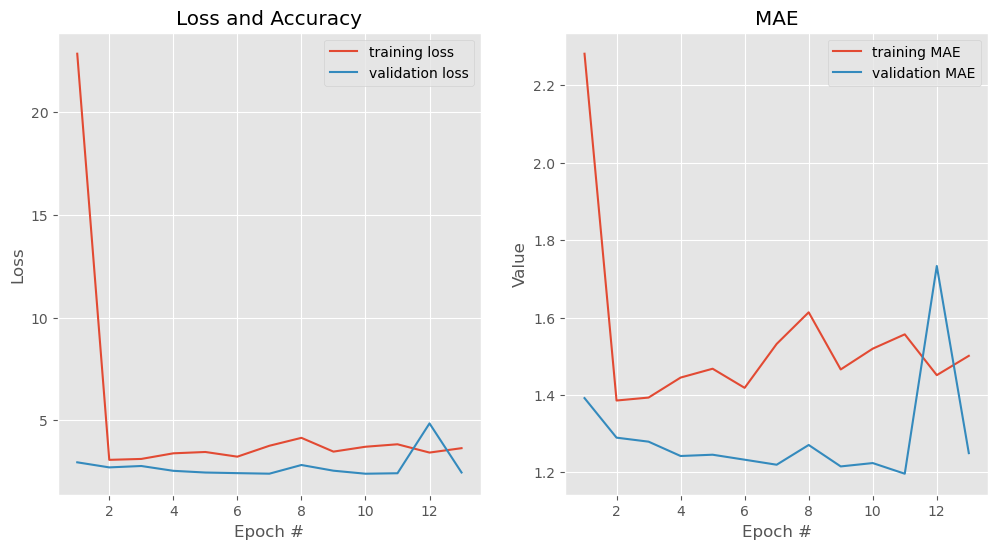

In [215]:
# Create a figure and two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Count number of epochs
epochs = len(history.history['loss'])

# Plot the loss and accuracy through training
ax1.plot(range(1, epochs + 1), history.history['loss'], label='training loss')
ax1.plot(range(1, epochs + 1), history.history['val_loss'], label='validation loss')
ax1.set_title('Loss and Accuracy')
ax1.set_xlabel('Epoch #')
ax1.set_ylabel('Loss')
ax1.legend()

# Plot MAE and RMAE
ax2.plot(range(1, epochs + 1), history.history['mean_absolute_error'], label='training MAE')
ax2.plot(range(1, epochs + 1), history.history['val_mean_absolute_error'], label='validation MAE')
# ax2.plot(range(1, maxEpoch + 1), history.history['rmae'], label='RMAE (Validation)')
# ax2.plot(range(1, maxEpoch + 1), history.history['train_rmae'], label='RMAE (Training)')
ax2.set_title('MAE')
ax2.set_xlabel('Epoch #')
ax2.set_ylabel('Value')
ax2.legend()

# Display the plot
plt.show()

Okay, there's a lot going on here, so let's break it down. First of all, we see a negative R2 value, which is not a good sign. This indicates that our model having a worse time predicting mana cost when compared to just selecting the mean value. This value is far from the ideal value of 1, therefore, we have. alot of underfitting occuring on the model. Additionally, we can see a peak in the validation loss at the later epochs, which indicates an instance of overfitting. This will be a problem in the future, but for now we can leave it be. Let's begin tuning some hyperparamters to see if we can get the model to have a positive R2 value. 

### Normalization

Let's try normalizing our data. This is always a good idea when dealing with neural networks, and even if we don't see much improvement it will be a good thing to have moving forward. 

In [216]:
from sklearn.preprocessing import StandardScaler

# Create an instance of the StandardScaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform it
trainX = scaler.fit_transform(trainX)
validX = scaler.transform(validX)
testX = scaler.transform(testX)

Now let's run our model again, this time with normalized data. 

In [217]:
# Create a feedforward neural net
model = Sequential()

# Create the layers
model.add(Dense(64, activation='relu', input_shape=(143,)))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='linear'))

# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam', 
              metrics=['mean_absolute_error'])

# Train the model
maxEpoch = 100
history = model.fit(trainX, trainY, epochs=maxEpoch, 
                    batch_size=32, 
                    validation_data=(validX, validY), 
                    callbacks=[early_stopping])

# Evaluate the model on the test set
loss, mae = model.evaluate(testX, testY)
print(f"Mean Squared Error: {loss}")
print(f"Mean Absolute Error: {mae}")

# Make predictions 
valid_predictions = model.predict(validX)

# Print r2 value
r2 = r2_score(testY, valid_predictions)
print(f"R-squared (R2): {r2}")

Epoch 1/100
427/427 [==============================] - 2s 3ms/step - loss: 3.3728 - mean_absolute_error: 1.4060 - val_loss: 2.5438 - val_mean_absolute_error: 1.2367
Epoch 2/100
427/427 [==============================] - 1s 2ms/step - loss: 2.4092 - mean_absolute_error: 1.2025 - val_loss: 2.4315 - val_mean_absolute_error: 1.1962
Epoch 3/100
427/427 [==============================] - 1s 2ms/step - loss: 2.2410 - mean_absolute_error: 1.1635 - val_loss: 2.3055 - val_mean_absolute_error: 1.1848
Epoch 4/100
427/427 [==============================] - 1s 2ms/step - loss: 2.1657 - mean_absolute_error: 1.1415 - val_loss: 2.2788 - val_mean_absolute_error: 1.1720
Epoch 5/100
427/427 [==============================] - 1s 2ms/step - loss: 2.1039 - mean_absolute_error: 1.1239 - val_loss: 2.2635 - val_mean_absolute_error: 1.1713
Epoch 6/100
427/427 [==============================] - 1s 2ms/step - loss: 2.0534 - mean_absolute_error: 1.1094 - val_loss: 2.2576 - val_mean_absolute_error: 1.1648
Epoch 7/10

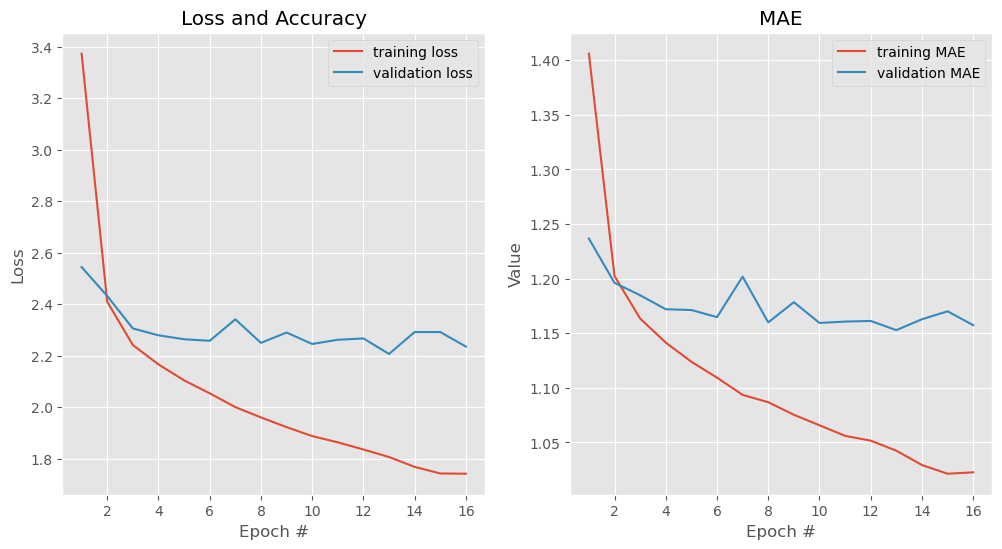

In [218]:
# Create a figure and two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Count number of epochs
epochs = len(history.history['loss'])

# Plot the loss and accuracy through training
ax1.plot(range(1, epochs + 1), history.history['loss'], label='training loss')
ax1.plot(range(1, epochs + 1), history.history['val_loss'], label='validation loss')
ax1.set_title('Loss and Accuracy')
ax1.set_xlabel('Epoch #')
ax1.set_ylabel('Loss')
ax1.legend()

# Plot MAE and RMAE
ax2.plot(range(1, epochs + 1), history.history['mean_absolute_error'], label='training MAE')
ax2.plot(range(1, epochs + 1), history.history['val_mean_absolute_error'], label='validation MAE')
# ax2.plot(range(1, maxEpoch + 1), history.history['rmae'], label='RMAE (Validation)')
# ax2.plot(range(1, maxEpoch + 1), history.history['train_rmae'], label='RMAE (Training)')
ax2.set_title('MAE')
ax2.set_xlabel('Epoch #')
ax2.set_ylabel('Value')
ax2.legend()

# Display the plot
plt.show()

Well, let's start with the good news. The model made it through more epochs, and shows a much clearner training curve. Unfortunately, there is a lot of bad news. First of all, we are seeing some major overfitting, as shown in both graphs where the validation loss is consistently larger than the training loss. Secondly, we also see our R2 value has gotten even worse. These are both problems that we have to fix, so let's start with the overfitting which we can fix using regularization. 

### Regularization

Let's try regularization using $L^1$ and $L^2$ kernal regularizers. We'll also include a droput rate of 0.5 after the dense layer of 64 units, and a dropout rate of 0.3 after the dense latyer of 32 units. This wil help prevent overfitting by randomly dropping out 50% and 30% of the neurons respectively. 

In [283]:
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.layers import Dropout

# Declare l1 and l2 values
l1 = 0.0
l2 = 0.0001

# Create a feedforward neural net
model = Sequential()

# Create the layers
model.add(Dense(64, activation='relu', input_shape=(143,), 
                kernel_regularizer = l1_l2(l1=l1, l2=l2)))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu', 
                kernel_regularizer = l1_l2(l1=l1, l2=l2)))
model.add(Dropout(0.3))
model.add(Dense(1, activation='linear', 
                kernel_regularizer = l1_l2(l1=l1, l2=l2)))

# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_absolute_error'])

# Train the model
maxEpoch = 100
history = model.fit(trainX, trainY, epochs=maxEpoch, batch_size=32, validation_data=(validX, validY), callbacks=[early_stopping])

# Evaluate the model on the test set
loss, mae = model.evaluate(testX, testY)
print(f"Mean Squared Error: {loss}")
print(f"Mean Absolute Error: {mae}")

# Make predictions
valid_predictions = model.predict(validX)

# Print r2 value
r2 = r2_score(testY, valid_predictions)
print(f"R-squared (R2): {r2}")

Epoch 1/100
427/427 [==============================] - 3s 3ms/step - loss: 4.4504 - mean_absolute_error: 1.6202 - val_loss: 3.2121 - val_mean_absolute_error: 1.3612
Epoch 2/100
427/427 [==============================] - 1s 3ms/step - loss: 3.3642 - mean_absolute_error: 1.4136 - val_loss: 2.8218 - val_mean_absolute_error: 1.2658
Epoch 3/100
427/427 [==============================] - 2s 4ms/step - loss: 2.9828 - mean_absolute_error: 1.3316 - val_loss: 2.6512 - val_mean_absolute_error: 1.2308
Epoch 4/100
427/427 [==============================] - 2s 4ms/step - loss: 2.8117 - mean_absolute_error: 1.2952 - val_loss: 2.5029 - val_mean_absolute_error: 1.2013
Epoch 5/100
427/427 [==============================] - 1s 3ms/step - loss: 2.6792 - mean_absolute_error: 1.2691 - val_loss: 2.4358 - val_mean_absolute_error: 1.1959
Epoch 6/100
427/427 [==============================] - 1s 3ms/step - loss: 2.5930 - mean_absolute_error: 1.2483 - val_loss: 2.4291 - val_mean_absolute_error: 1.1980
Epoch 7/10

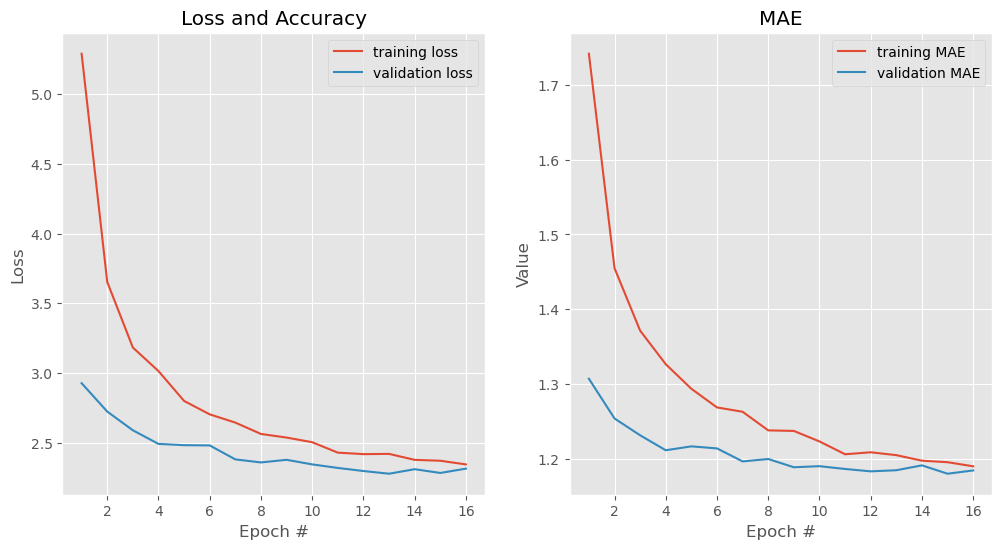

In [233]:
# Create a figure and two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Count number of epochs
epochs = len(history.history['loss'])

# Plot the loss and accuracy through training
ax1.plot(range(1, epochs + 1), history.history['loss'], label='training loss')
ax1.plot(range(1, epochs + 1), history.history['val_loss'], label='validation loss')
ax1.set_title('Loss and Accuracy')
ax1.set_xlabel('Epoch #')
ax1.set_ylabel('Loss')
ax1.legend()

# Plot MAE and RMAE
ax2.plot(range(1, epochs + 1), history.history['mean_absolute_error'], label='training MAE')
ax2.plot(range(1, epochs + 1), history.history['val_mean_absolute_error'], label='validation MAE')
# ax2.plot(range(1, maxEpoch + 1), history.history['rmae'], label='RMAE (Validation)')
# ax2.plot(range(1, maxEpoch + 1), history.history['train_rmae'], label='RMAE (Training)')
ax2.set_title('MAE')
ax2.set_xlabel('Epoch #')
ax2.set_ylabel('Value')
ax2.legend()

# Display the plot
plt.show()

The good news is that we have fixed our overfitting problem, as shown by the fact that the training loss consistently remains higher than the validation loss. Unfortunately, it is still getting dangerously close towards the later epochs, so we may have to look into it again later on. We can also note that our R2 value has gotten a little better since last time, so we are on the right track. Now that overfitting is out of the way, we can tackle underfitting which we can try to fix by increasing the complexity of the model architecture. 

### Architecture

Let's try adding more layers to our network and see if that helps. To do this, we'll add a dense 128 layer at the beginning of the model. 

In [234]:
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.layers import Dropout

# Declare L1 and L2 values
l1 = 0.0
l2 = 0.0001

# Create a feedforward neural net
model = Sequential()

# Create the layers
model.add(Dense(128, activation='relu', input_shape=(143,), kernel_regularizer = l1_l2(l1=l1, l2=l2)))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu', kernel_regularizer = l1_l2(l1=l1, l2=l2)))
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu', kernel_regularizer = l1_l2(l1=l1, l2=l2)))
model.add(Dropout(0.1))
model.add(Dense(1, activation='linear', kernel_regularizer = l1_l2(l1=l1, l2=l2)))

# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_absolute_error'])

# Train the model
maxEpoch = 100
history = model.fit(trainX, trainY, epochs=maxEpoch, batch_size=32, validation_data=(validX, validY), callbacks=[early_stopping])

# Evaluate the model on the test set
loss, mae = model.evaluate(testX, testY)
print(f"Mean Squared Error: {loss}")
print(f"Mean Absolute Error: {mae}")

# Make predictions
valid_predictions = model.predict(validX)

# Print r2 value
r2 = r2_score(testY, valid_predictions)
print(f"R-squared (R2): {r2}")

Epoch 1/100
427/427 [==============================] - 3s 3ms/step - loss: 4.2631 - mean_absolute_error: 1.5550 - val_loss: 3.2054 - val_mean_absolute_error: 1.3602
Epoch 2/100
427/427 [==============================] - 2s 5ms/step - loss: 3.0170 - mean_absolute_error: 1.3404 - val_loss: 2.9924 - val_mean_absolute_error: 1.2968
Epoch 3/100
427/427 [==============================] - 2s 4ms/step - loss: 2.7287 - mean_absolute_error: 1.2816 - val_loss: 3.0194 - val_mean_absolute_error: 1.3074
Epoch 4/100
427/427 [==============================] - 1s 3ms/step - loss: 2.6219 - mean_absolute_error: 1.2566 - val_loss: 2.6339 - val_mean_absolute_error: 1.2401
Epoch 5/100
427/427 [==============================] - 1s 3ms/step - loss: 2.5261 - mean_absolute_error: 1.2320 - val_loss: 2.4622 - val_mean_absolute_error: 1.1957
Epoch 6/100
427/427 [==============================] - 1s 3ms/step - loss: 2.4597 - mean_absolute_error: 1.2189 - val_loss: 2.5224 - val_mean_absolute_error: 1.2024
Epoch 7/10

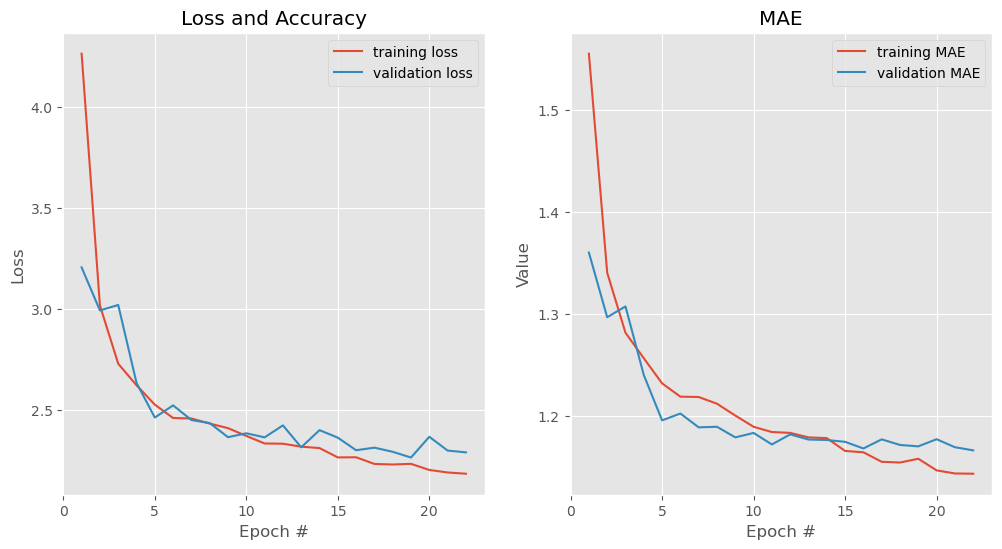

In [235]:
# Create a figure and two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Count number of epochs
epochs = len(history.history['loss'])

# Plot the loss and accuracy through training
ax1.plot(range(1, epochs + 1), history.history['loss'], label='training loss')
ax1.plot(range(1, epochs + 1), history.history['val_loss'], label='validation loss')
ax1.set_title('Loss and Accuracy')
ax1.set_xlabel('Epoch #')
ax1.set_ylabel('Loss')
ax1.legend()

# Plot MAE and RMAE
ax2.plot(range(1, epochs + 1), history.history['mean_absolute_error'], label='training MAE')
ax2.plot(range(1, epochs + 1), history.history['val_mean_absolute_error'], label='validation MAE')
# ax2.plot(range(1, maxEpoch + 1), history.history['rmae'], label='RMAE (Validation)')
# ax2.plot(range(1, maxEpoch + 1), history.history['train_rmae'], label='RMAE (Training)')
ax2.set_title('MAE')
ax2.set_xlabel('Epoch #')
ax2.set_ylabel('Value')
ax2.legend()

# Display the plot
plt.show()

Here we see more epochs, which is good, but not much improvement. We also see some overfitting again. We're still using a very small L2 value for regularization, so let's try increasing that again. 

In [285]:
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.layers import Dropout

# Declare l1 and l2 values
l1 = 0.0
l2 = 0.1

# Create a feedforward neural net
model = Sequential()

# Create the layers
model.add(Dense(128, activation='relu', input_shape=(143,), kernel_regularizer = l1_l2(l1=l1, l2=l2)))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu', kernel_regularizer = l1_l2(l1=l1, l2=l2)))
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu', kernel_regularizer = l1_l2(l1=l1, l2=l2)))
model.add(Dropout(0.1))
model.add(Dense(1, activation='linear', kernel_regularizer = l1_l2(l1=l1, l2=l2)))

# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_absolute_error'])

# Train the model
maxEpoch = 100
history = model.fit(trainX, trainY, epochs=maxEpoch, batch_size=32, validation_data=(validX, validY), callbacks=[early_stopping])

# Evaluate the model on the test set
loss, mae = model.evaluate(testX, testY)
print(f"Mean Squared Error: {loss}")
print(f"Mean Absolute Error: {mae}")

# Make predictions
valid_predictions = model.predict(validX)

# Print r2 value
r2 = r2_score(testY, valid_predictions)
print(f"R-squared (R2): {r2}")

Epoch 1/100
427/427 [==============================] - 3s 3ms/step - loss: 15.6309 - mean_absolute_error: 1.5187 - val_loss: 6.6844 - val_mean_absolute_error: 1.2570
Epoch 2/100
427/427 [==============================] - 1s 3ms/step - loss: 4.8432 - mean_absolute_error: 1.2807 - val_loss: 3.5312 - val_mean_absolute_error: 1.2323
Epoch 3/100
427/427 [==============================] - 1s 3ms/step - loss: 3.3578 - mean_absolute_error: 1.2615 - val_loss: 3.1036 - val_mean_absolute_error: 1.2702
Epoch 4/100
427/427 [==============================] - 1s 3ms/step - loss: 3.0703 - mean_absolute_error: 1.2534 - val_loss: 2.9202 - val_mean_absolute_error: 1.2354
Epoch 5/100
427/427 [==============================] - 1s 3ms/step - loss: 3.0067 - mean_absolute_error: 1.2571 - val_loss: 2.9005 - val_mean_absolute_error: 1.2477
Epoch 6/100
427/427 [==============================] - 1s 3ms/step - loss: 2.9881 - mean_absolute_error: 1.2592 - val_loss: 2.8512 - val_mean_absolute_error: 1.2224
Epoch 7/1

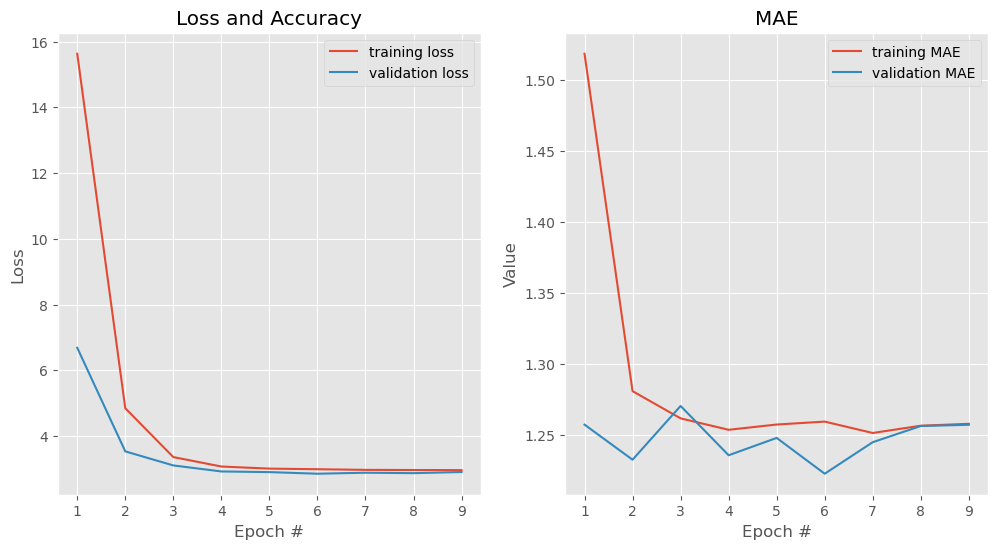

In [286]:
# Create a figure and two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Count number of epochs
epochs = len(history.history['loss'])

# Plot the loss and accuracy through training
ax1.plot(range(1, epochs + 1), history.history['loss'], label='training loss')
ax1.plot(range(1, epochs + 1), history.history['val_loss'], label='validation loss')
ax1.set_title('Loss and Accuracy')
ax1.set_xlabel('Epoch #')
ax1.set_ylabel('Loss')
ax1.legend()

# Plot MAE and RMAE
ax2.plot(range(1, epochs + 1), history.history['mean_absolute_error'], label='training MAE')
ax2.plot(range(1, epochs + 1), history.history['val_mean_absolute_error'], label='validation MAE')
# ax2.plot(range(1, maxEpoch + 1), history.history['rmae'], label='RMAE (Validation)')
# ax2.plot(range(1, maxEpoch + 1), history.history['train_rmae'], label='RMAE (Training)')
ax2.set_title('MAE')
ax2.set_xlabel('Epoch #')
ax2.set_ylabel('Value')
ax2.legend()

# Display the plot
plt.show()

We once again have overfitting close to being under control so let's keep trying to reduce underfitting with more layers. For this we'll add some additional dense layers: one at 256, one at 16, and one at 8. Let's also make sure to adjust the dropout rates accordingly. 

In [289]:
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.layers import Dropout

# Declare l1 and l2 values
l1 = 0.0
l2 = 0.1

# Create a feedforward neural net
model = Sequential()

# Create the layers
model.add(Dense(256, activation='relu', input_shape=(143,), 
                kernel_regularizer = l1_l2(l1=l1, l2=l2)))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu', 
                kernel_regularizer = l1_l2(l1=l1, l2=l2)))
model.add(Dropout(0.4))
model.add(Dense(64, activation='relu', 
                kernel_regularizer = l1_l2(l1=l1, l2=l2)))
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu', 
                kernel_regularizer = l1_l2(l1=l1, l2=l2)))
model.add(Dropout(0.1))
model.add(Dense(16, activation='relu', 
                kernel_regularizer = l1_l2(l1=l1, l2=l2)))
model.add(Dropout(0.1))
model.add(Dense(8, activation='relu', 
                kernel_regularizer = l1_l2(l1=l1, l2=l2)))
model.add(Dropout(0.1))
model.add(Dense(1, activation='linear', 
                kernel_regularizer = l1_l2(l1=l1, l2=l2)))

# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_absolute_error'])

# Train the model
maxEpoch = 100
history = model.fit(trainX, trainY, epochs=maxEpoch, batch_size=32, validation_data=(validX, validY), callbacks=[early_stopping])

# Evaluate the model on the test set
loss, mae = model.evaluate(testX, testY)
print(f"Mean Squared Error: {loss}")
print(f"Mean Absolute Error: {mae}")

# Make predictions
valid_predictions = model.predict(validX)

# Print r2 value
r2 = r2_score(testY, valid_predictions)
print(f"R-squared (R2): {r2}")

Epoch 1/100
427/427 [==============================] - 5s 5ms/step - loss: 17.7775 - mean_absolute_error: 1.7402 - val_loss: 4.8904 - val_mean_absolute_error: 1.2675
Epoch 2/100
427/427 [==============================] - 2s 5ms/step - loss: 4.7770 - mean_absolute_error: 1.4324 - val_loss: 3.6157 - val_mean_absolute_error: 1.2772
Epoch 3/100
427/427 [==============================] - 2s 4ms/step - loss: 4.0874 - mean_absolute_error: 1.4106 - val_loss: 3.3699 - val_mean_absolute_error: 1.2735
Epoch 4/100
427/427 [==============================] - 2s 4ms/step - loss: 3.8380 - mean_absolute_error: 1.3888 - val_loss: 3.3224 - val_mean_absolute_error: 1.2913
Epoch 5/100
427/427 [==============================] - 2s 4ms/step - loss: 3.7392 - mean_absolute_error: 1.3833 - val_loss: 3.3437 - val_mean_absolute_error: 1.3065
Epoch 6/100
427/427 [==============================] - 2s 4ms/step - loss: 3.6484 - mean_absolute_error: 1.3713 - val_loss: 3.2618 - val_mean_absolute_error: 1.3018
Epoch 7/1

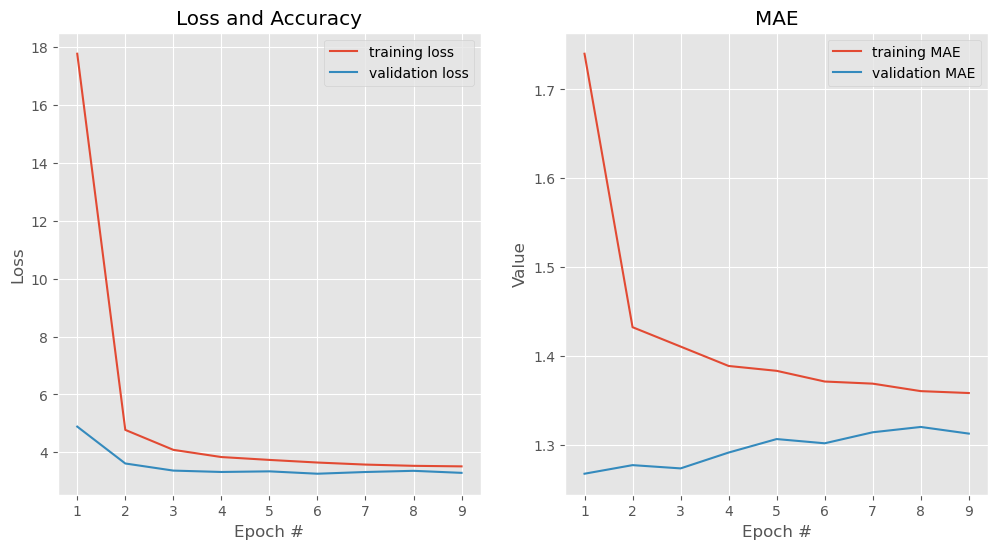

In [290]:
# Create a figure and two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Count number of epochs
epochs = len(history.history['loss'])

# Plot the loss and accuracy through training
ax1.plot(range(1, epochs + 1), history.history['loss'], label='training loss')
ax1.plot(range(1, epochs + 1), history.history['val_loss'], label='validation loss')
ax1.set_title('Loss and Accuracy')
ax1.set_xlabel('Epoch #')
ax1.set_ylabel('Loss')
ax1.legend()

# Plot MAE and RMAE
ax2.plot(range(1, epochs + 1), history.history['mean_absolute_error'], label='training MAE')
ax2.plot(range(1, epochs + 1), history.history['val_mean_absolute_error'], label='validation MAE')
# ax2.plot(range(1, maxEpoch + 1), history.history['rmae'], label='RMAE (Validation)')
# ax2.plot(range(1, maxEpoch + 1), history.history['train_rmae'], label='RMAE (Training)')
ax2.set_title('MAE')
ax2.set_xlabel('Epoch #')
ax2.set_ylabel('Value')
ax2.legend()

# Display the plot
plt.show()

Here we don't see any overfitting, and we have reduced our R2 value even further. It still is a negative value, which is not ideal, but increasing our model will only take us so far, so let's try some other techniques in the meantime.

### Activation Function

Let's try a variation of our `relu` activation, using a Leaky ReLU. This function adds a small gradient for negative outputs, determined by the $\alpha$ parameter. For the purposes of our experiment, we'll leave this $\alpha$ as a very small number, `0.1`, for slight improvement. Note that the Leaky ReLU will only be applied to the itermediate layers, while the output remains as `softmax`. 

In [293]:
from tensorflow.keras.layers import LeakyReLU 

In [299]:
# Create a feedforward neural net
model = Sequential()

# Create the layers
model.add(Dense(256, activation=LeakyReLU(alpha=0.1), input_shape=(143,), 
                kernel_regularizer = l1_l2(l1=l1, l2=l2)))
model.add(Dropout(0.5))
model.add(Dense(128, activation=LeakyReLU(alpha=0.1), 
                kernel_regularizer = l1_l2(l1=l1, l2=l2)))
model.add(Dropout(0.4))
model.add(Dense(64, activation=LeakyReLU(alpha=0.1), 
                kernel_regularizer = l1_l2(l1=l1, l2=l2)))
model.add(Dropout(0.3))
model.add(Dense(32, activation=LeakyReLU(alpha=0.1), 
                kernel_regularizer = l1_l2(l1=l1, l2=l2)))
model.add(Dropout(0.1))
model.add(Dense(16, activation=LeakyReLU(alpha=0.1), 
                kernel_regularizer = l1_l2(l1=l1, l2=l2)))
model.add(Dropout(0.1))
model.add(Dense(8, activation=LeakyReLU(alpha=0.1), 
                kernel_regularizer = l1_l2(l1=l1, l2=l2)))
model.add(Dropout(0.1))
model.add(Dense(1, activation='linear', 
                kernel_regularizer = l1_l2(l1=l1, l2=l2)))

# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_absolute_error'])

# Train the model
maxEpoch = 100
history = model.fit(trainX, trainY, epochs=maxEpoch, batch_size=32, validation_data=(validX, validY), callbacks=[early_stopping])

# Evaluate the model on the test set
loss, mae = model.evaluate(testX, testY)
print(f"Mean Squared Error: {loss}")
print(f"Mean Absolute Error: {mae}")

# Make predictions
valid_predictions = model.predict(validX)

# Print r2 value
r2 = r2_score(testY, valid_predictions)
print(f"R-squared (R2): {r2}")

Epoch 1/100
427/427 [==============================] - 4s 5ms/step - loss: 21.0138 - mean_absolute_error: 1.5850 - val_loss: 6.3064 - val_mean_absolute_error: 1.2768
Epoch 2/100
427/427 [==============================] - 2s 5ms/step - loss: 5.0614 - mean_absolute_error: 1.3793 - val_loss: 3.7617 - val_mean_absolute_error: 1.2822
Epoch 3/100
427/427 [==============================] - 2s 5ms/step - loss: 3.9444 - mean_absolute_error: 1.3647 - val_loss: 3.4391 - val_mean_absolute_error: 1.2849
Epoch 4/100
427/427 [==============================] - 2s 4ms/step - loss: 3.6872 - mean_absolute_error: 1.3551 - val_loss: 3.3451 - val_mean_absolute_error: 1.2986
Epoch 5/100
427/427 [==============================] - 2s 5ms/step - loss: 3.5762 - mean_absolute_error: 1.3422 - val_loss: 3.3130 - val_mean_absolute_error: 1.3083
Epoch 6/100
427/427 [==============================] - 2s 5ms/step - loss: 3.5474 - mean_absolute_error: 1.3499 - val_loss: 3.2961 - val_mean_absolute_error: 1.3107
Epoch 7/1

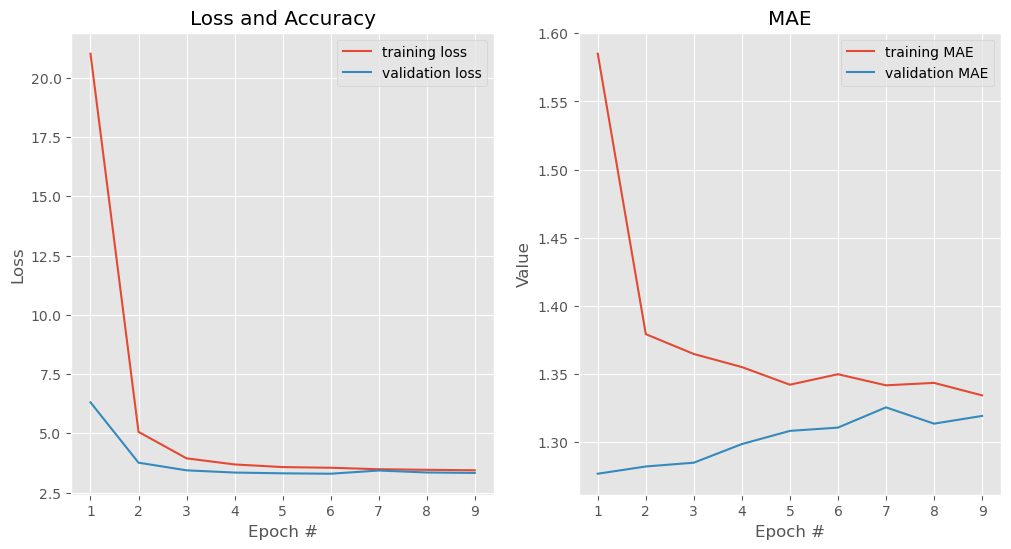

In [300]:
# Create a figure and two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Count number of epochs
epochs = len(history.history['loss'])

# Plot the loss and accuracy through training
ax1.plot(range(1, epochs + 1), history.history['loss'], label='training loss')
ax1.plot(range(1, epochs + 1), history.history['val_loss'], label='validation loss')
ax1.set_title('Loss and Accuracy')
ax1.set_xlabel('Epoch #')
ax1.set_ylabel('Loss')
ax1.legend()

# Plot MAE and RMAE
ax2.plot(range(1, epochs + 1), history.history['mean_absolute_error'], label='training MAE')
ax2.plot(range(1, epochs + 1), history.history['val_mean_absolute_error'], label='validation MAE')
# ax2.plot(range(1, maxEpoch + 1), history.history['rmae'], label='RMAE (Validation)')
# ax2.plot(range(1, maxEpoch + 1), history.history['train_rmae'], label='RMAE (Training)')
ax2.set_title('MAE')
ax2.set_xlabel('Epoch #')
ax2.set_ylabel('Value')
ax2.legend()

# Display the plot
plt.show()

Here we see that the LeakyReLU model preforms as well if not slightly better than our original relu model, displaying a better R2 value while maintaining a non-overfitting model.

Let's try PReLU, which is similar to LeakyReLU, with the key difference being the slope of the negative part of the function is learned during training, rather than being a fixed hyperparameter.

In [295]:
from tensorflow.keras.layers import PReLU 

In [296]:
# Create a feedforward neural net
model = Sequential()

# Declare l1 and l2 values
l1 = 0.0
l2 = 0.1

# Create the layers
model.add(Dense(256, activation=PReLU(), input_shape=(143,), kernel_regularizer = l1_l2(l1=l1, l2=l2)))
model.add(Dropout(0.5))
model.add(Dense(128, activation=PReLU(), kernel_regularizer = l1_l2(l1=l1, l2=l2)))
model.add(Dropout(0.4))
model.add(Dense(64, activation=PReLU(), kernel_regularizer = l1_l2(l1=l1, l2=l2)))
model.add(Dropout(0.3))
model.add(Dense(32, activation=PReLU(), kernel_regularizer = l1_l2(l1=l1, l2=l2)))
model.add(Dropout(0.1))
model.add(Dense(16, activation=PReLU(), kernel_regularizer = l1_l2(l1=l1, l2=l2)))
model.add(Dropout(0.1))
model.add(Dense(8, activation=PReLU(), kernel_regularizer = l1_l2(l1=l1, l2=l2)))
model.add(Dropout(0.1))
model.add(Dense(1, activation='linear', kernel_regularizer = l1_l2(l1=l1, l2=l2)))

# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_absolute_error'])

# Train the model
maxEpoch = 100
history = model.fit(trainX, trainY, epochs=maxEpoch, batch_size=32, validation_data=(validX, validY), callbacks=[early_stopping])

# Evaluate the model on the test set
loss, mae = model.evaluate(testX, testY)
print(f"Mean Squared Error: {loss}")
print(f"Mean Absolute Error: {mae}")

# Make predictions
valid_predictions = model.predict(validX)

# Print r2 value
r2 = r2_score(testY, valid_predictions)
print(f"R-squared (R2): {r2}")

Epoch 1/100
427/427 [==============================] - 4s 5ms/step - loss: 21.3631 - mean_absolute_error: 1.5615 - val_loss: 6.7435 - val_mean_absolute_error: 1.2925
Epoch 2/100
427/427 [==============================] - 2s 5ms/step - loss: 5.1597 - mean_absolute_error: 1.3556 - val_loss: 4.0690 - val_mean_absolute_error: 1.2958
Epoch 3/100
427/427 [==============================] - 2s 6ms/step - loss: 3.9814 - mean_absolute_error: 1.3486 - val_loss: 3.4986 - val_mean_absolute_error: 1.2931
Epoch 4/100
427/427 [==============================] - 2s 5ms/step - loss: 3.6899 - mean_absolute_error: 1.3465 - val_loss: 3.4286 - val_mean_absolute_error: 1.2888
Epoch 5/100
427/427 [==============================] - 2s 5ms/step - loss: 3.5859 - mean_absolute_error: 1.3355 - val_loss: 3.3680 - val_mean_absolute_error: 1.2887
Epoch 6/100
427/427 [==============================] - 2s 5ms/step - loss: 3.5087 - mean_absolute_error: 1.3291 - val_loss: 3.2776 - val_mean_absolute_error: 1.2878
Epoch 7/1

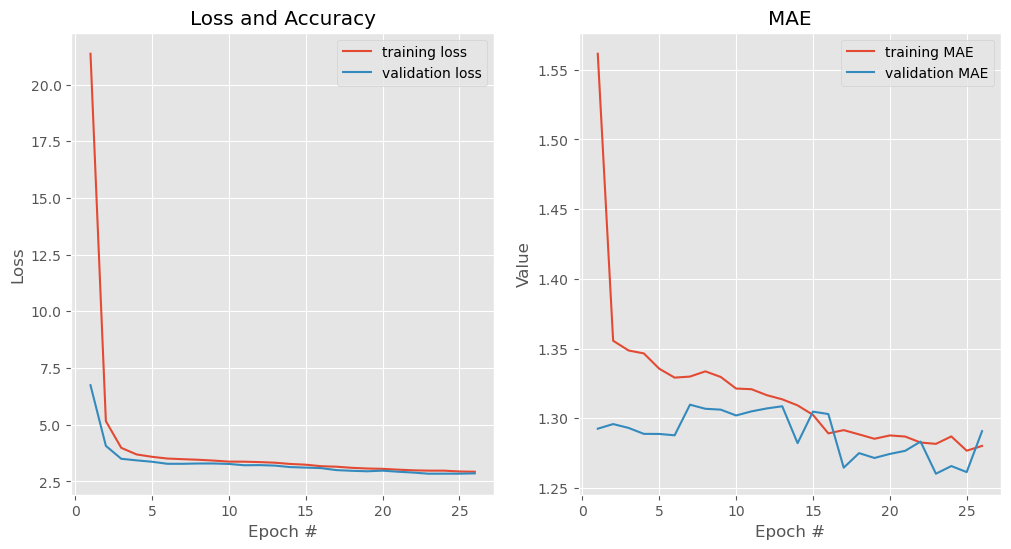

In [298]:
# Create a figure and two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Count number of epochs
epochs = len(history.history['loss'])

# Plot the loss and accuracy through training
ax1.plot(range(1, epochs + 1), history.history['loss'], label='training loss')
ax1.plot(range(1, epochs + 1), history.history['val_loss'], label='validation loss')
ax1.set_title('Loss and Accuracy')
ax1.set_xlabel('Epoch #')
ax1.set_ylabel('Loss')
ax1.legend()

# Plot MAE and RMAE
ax2.plot(range(1, epochs + 1), history.history['mean_absolute_error'], label='training MAE')
ax2.plot(range(1, epochs + 1), history.history['val_mean_absolute_error'], label='validation MAE')
# ax2.plot(range(1, maxEpoch + 1), history.history['rmae'], label='RMAE (Validation)')
# ax2.plot(range(1, maxEpoch + 1), history.history['train_rmae'], label='RMAE (Training)')
ax2.set_title('MAE')
ax2.set_xlabel('Epoch #')
ax2.set_ylabel('Value')
ax2.legend()

# Display the plot
plt.show()

Unfortunately, the PReLU model is not nearly as successful, so we'll stick to the LeakyReLU model from now on.

### Loss Function

Throughout our experimentation, we have been using the `mean_squared error` as our loss function of choice, while also calculating other values such as `mean_absolute_error`. So what if we tried compiling with the MAE instead?

In [311]:
# Create a feedforward neural net
model = Sequential()

# Declare l1 and l2 values
l1 = 0.0
l2 = 0.1

# Create the layers
model.add(Dense(256, activation=LeakyReLU(alpha=0.1), input_shape=(143,), kernel_regularizer = l1_l2(l1=l1, l2=l2)))
model.add(Dropout(0.5))
model.add(Dense(128, activation=LeakyReLU(alpha=0.1), kernel_regularizer = l1_l2(l1=l1, l2=l2)))
model.add(Dropout(0.4))
model.add(Dense(64, activation=LeakyReLU(alpha=0.1), kernel_regularizer = l1_l2(l1=l1, l2=l2)))
model.add(Dropout(0.3))
model.add(Dense(32, activation=LeakyReLU(alpha=0.1), kernel_regularizer = l1_l2(l1=l1, l2=l2)))
model.add(Dropout(0.1))
model.add(Dense(16, activation=LeakyReLU(alpha=0.1), kernel_regularizer = l1_l2(l1=l1, l2=l2)))
model.add(Dropout(0.1))
model.add(Dense(8, activation=LeakyReLU(alpha=0.1), kernel_regularizer = l1_l2(l1=l1, l2=l2)))
model.add(Dropout(0.1))
model.add(Dense(1, activation='linear', kernel_regularizer = l1_l2(l1=l1, l2=l2)))

# Compile the model
model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])

# Train the model
maxEpoch = 100
history = model.fit(trainX, trainY, epochs=maxEpoch, batch_size=32, validation_data=(validX, validY), callbacks=[early_stopping])

# Evaluate the model on the test set
loss, mae = model.evaluate(testX, testY)
print(f"Mean Squared Error: {loss}")
print(f"Mean Absolute Error: {mae}")

# Make predictions
valid_predictions = model.predict(validX)

# Print r2 value
r2 = r2_score(testY, valid_predictions)
print(f"R-squared (R2): {r2}")

Epoch 1/100
427/427 [==============================] - 4s 5ms/step - loss: 8.1277 - mean_absolute_error: 1.7358 - val_loss: 1.9498 - val_mean_absolute_error: 1.4876
Epoch 2/100
427/427 [==============================] - 2s 4ms/step - loss: 1.8073 - mean_absolute_error: 1.4988 - val_loss: 1.6618 - val_mean_absolute_error: 1.4399
Epoch 3/100
427/427 [==============================] - 2s 5ms/step - loss: 1.6274 - mean_absolute_error: 1.4399 - val_loss: 1.5890 - val_mean_absolute_error: 1.4394
Epoch 4/100
427/427 [==============================] - 2s 5ms/step - loss: 1.5533 - mean_absolute_error: 1.4232 - val_loss: 1.5124 - val_mean_absolute_error: 1.4002
Epoch 5/100
427/427 [==============================] - 2s 4ms/step - loss: 1.5045 - mean_absolute_error: 1.4086 - val_loss: 1.4873 - val_mean_absolute_error: 1.4042
Epoch 6/100
427/427 [==============================] - 2s 4ms/step - loss: 1.4691 - mean_absolute_error: 1.3972 - val_loss: 1.4666 - val_mean_absolute_error: 1.4034
Epoch 7/10

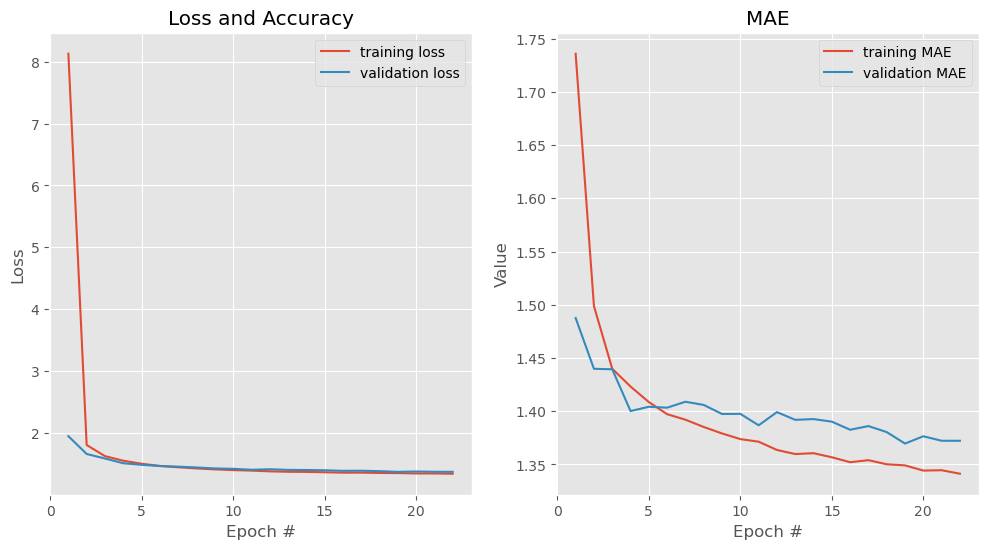

In [312]:
# Create a figure and two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Count number of epochs
epochs = len(history.history['loss'])

# Plot the loss and accuracy through training
ax1.plot(range(1, epochs + 1), history.history['loss'], label='training loss')
ax1.plot(range(1, epochs + 1), history.history['val_loss'], label='validation loss')
ax1.set_title('Loss and Accuracy')
ax1.set_xlabel('Epoch #')
ax1.set_ylabel('Loss')
ax1.legend()

# Plot MAE and RMAE
ax2.plot(range(1, epochs + 1), history.history['mean_absolute_error'], label='training MAE')
ax2.plot(range(1, epochs + 1), history.history['val_mean_absolute_error'], label='validation MAE')
# ax2.plot(range(1, maxEpoch + 1), history.history['rmae'], label='RMAE (Validation)')
# ax2.plot(range(1, maxEpoch + 1), history.history['train_rmae'], label='RMAE (Training)')
ax2.set_title('MAE')
ax2.set_xlabel('Epoch #')
ax2.set_ylabel('Value')
ax2.legend()

# Display the plot
plt.show()

Not great, a lot of overfitting is seen here. Maybe we can salvage it with some more L2 tweaking.

In [313]:
# Create a feedforward neural net
model = Sequential()

# Declare l1 and l2 values
l1 = 0.0
l2 = 1

# Create the layers
model.add(Dense(256, activation=LeakyReLU(alpha=0.1), input_shape=(143,), kernel_regularizer = l1_l2(l1=l1, l2=l2)))
model.add(Dropout(0.5))
model.add(Dense(128, activation=LeakyReLU(alpha=0.1), kernel_regularizer = l1_l2(l1=l1, l2=l2)))
model.add(Dropout(0.4))
model.add(Dense(64, activation=LeakyReLU(alpha=0.1), kernel_regularizer = l1_l2(l1=l1, l2=l2)))
model.add(Dropout(0.3))
model.add(Dense(32, activation=LeakyReLU(alpha=0.1), kernel_regularizer = l1_l2(l1=l1, l2=l2)))
model.add(Dropout(0.1))
model.add(Dense(16, activation=LeakyReLU(alpha=0.1), kernel_regularizer = l1_l2(l1=l1, l2=l2)))
model.add(Dropout(0.1))
model.add(Dense(8, activation=LeakyReLU(alpha=0.1), kernel_regularizer = l1_l2(l1=l1, l2=l2)))
model.add(Dropout(0.1))
model.add(Dense(1, activation='linear', kernel_regularizer = l1_l2(l1=l1, l2=l2)))

# Compile the model
model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])

# Train the model
maxEpoch = 100
history = model.fit(trainX, trainY, epochs=maxEpoch, batch_size=32, validation_data=(validX, validY), callbacks=[early_stopping])

# Evaluate the model on the test set
loss, mae = model.evaluate(testX, testY)
print(f"Mean Squared Error: {loss}")
print(f"Mean Absolute Error: {mae}")

# Make predictions
valid_predictions = model.predict(validX)

# Print r2 value
r2 = r2_score(testY, valid_predictions)
print(f"R-squared (R2): {r2}")

Epoch 1/100
427/427 [==============================] - 4s 5ms/step - loss: 59.4187 - mean_absolute_error: 2.8002 - val_loss: 3.4429 - val_mean_absolute_error: 2.2717
Epoch 2/100
427/427 [==============================] - 2s 4ms/step - loss: 2.4708 - mean_absolute_error: 1.8577 - val_loss: 2.0859 - val_mean_absolute_error: 1.7546
Epoch 3/100
427/427 [==============================] - 2s 4ms/step - loss: 1.9290 - mean_absolute_error: 1.6364 - val_loss: 1.8458 - val_mean_absolute_error: 1.5799
Epoch 4/100
427/427 [==============================] - 2s 4ms/step - loss: 1.7461 - mean_absolute_error: 1.4930 - val_loss: 1.6997 - val_mean_absolute_error: 1.4368
Epoch 5/100
427/427 [==============================] - 2s 4ms/step - loss: 1.6096 - mean_absolute_error: 1.3910 - val_loss: 1.5910 - val_mean_absolute_error: 1.4136
Epoch 6/100
427/427 [==============================] - 2s 4ms/step - loss: 1.5263 - mean_absolute_error: 1.3812 - val_loss: 1.5244 - val_mean_absolute_error: 1.4078
Epoch 7/1

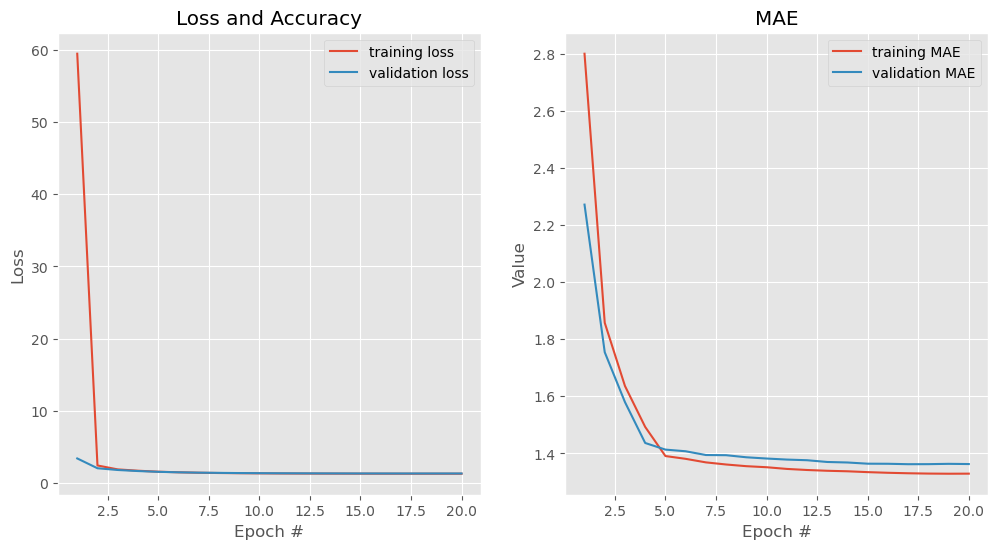

In [314]:
# Create a figure and two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Count number of epochs
epochs = len(history.history['loss'])

# Plot the loss and accuracy through training
ax1.plot(range(1, epochs + 1), history.history['loss'], label='training loss')
ax1.plot(range(1, epochs + 1), history.history['val_loss'], label='validation loss')
ax1.set_title('Loss and Accuracy')
ax1.set_xlabel('Epoch #')
ax1.set_ylabel('Loss')
ax1.legend()

# Plot MAE and RMAE
ax2.plot(range(1, epochs + 1), history.history['mean_absolute_error'], label='training MAE')
ax2.plot(range(1, epochs + 1), history.history['val_mean_absolute_error'], label='validation MAE')
# ax2.plot(range(1, maxEpoch + 1), history.history['rmae'], label='RMAE (Validation)')
# ax2.plot(range(1, maxEpoch + 1), history.history['train_rmae'], label='RMAE (Training)')
ax2.set_title('MAE')
ax2.set_xlabel('Epoch #')
ax2.set_ylabel('Value')
ax2.legend()

# Display the plot
plt.show()

Still not able to salvage this even with some L2 tweaking, as we still see overfitting, but we're fine with that and we can stick to using `mean_squared_error` moving forward.

We can also try a logarithmic loss function using `mean_squared_logarithmic_error` as a loss funciton. It is unlikely that this will help, as our target values do not seem to be experiencing exponential growth, but it still worth a shot. 

In [315]:
# Create a feedforward neural net
model = Sequential()

# Declare l1 and l2 values
l1 = 0.0
l2 = 0.1

# Create the layers
model.add(Dense(256, activation=LeakyReLU(alpha=0.1), input_shape=(143,), kernel_regularizer = l1_l2(l1=l1, l2=l2)))
model.add(Dropout(0.5))
model.add(Dense(128, activation=LeakyReLU(alpha=0.1), kernel_regularizer = l1_l2(l1=l1, l2=l2)))
model.add(Dropout(0.4))
model.add(Dense(64, activation=LeakyReLU(alpha=0.1), kernel_regularizer = l1_l2(l1=l1, l2=l2)))
model.add(Dropout(0.3))
model.add(Dense(32, activation=LeakyReLU(alpha=0.1), kernel_regularizer = l1_l2(l1=l1, l2=l2)))
model.add(Dropout(0.1))
model.add(Dense(16, activation=LeakyReLU(alpha=0.1), kernel_regularizer = l1_l2(l1=l1, l2=l2)))
model.add(Dropout(0.1))
model.add(Dense(8, activation=LeakyReLU(alpha=0.1), kernel_regularizer = l1_l2(l1=l1, l2=l2)))
model.add(Dropout(0.1))
model.add(Dense(1, activation='linear', kernel_regularizer = l1_l2(l1=l1, l2=l2)))

# Compile the model
model.compile(loss='mean_squared_logarithmic_error', optimizer='adam', metrics=['mean_absolute_error'])

# Train the model
maxEpoch = 100
history = model.fit(trainX, trainY, epochs=maxEpoch, batch_size=32, validation_data=(validX, validY), callbacks=[early_stopping])

# Evaluate the model on the test set
loss, mae = model.evaluate(testX, testY)
print(f"Mean Squared Error: {loss}")
print(f"Mean Absolute Error: {mae}")

# Make predictions
valid_predictions = model.predict(validX)

# Print r2 value
r2 = r2_score(testY, valid_predictions)
print(f"R-squared (R2): {r2}")

Epoch 1/100
427/427 [==============================] - 4s 5ms/step - loss: 6.8200 - mean_absolute_error: 1.6475 - val_loss: 0.5874 - val_mean_absolute_error: 1.5531
Epoch 2/100
427/427 [==============================] - 2s 4ms/step - loss: 0.4435 - mean_absolute_error: 1.5147 - val_loss: 0.3645 - val_mean_absolute_error: 1.5184
Epoch 3/100
427/427 [==============================] - 2s 4ms/step - loss: 0.3330 - mean_absolute_error: 1.4779 - val_loss: 0.3123 - val_mean_absolute_error: 1.5101
Epoch 4/100
427/427 [==============================] - 2s 4ms/step - loss: 0.2925 - mean_absolute_error: 1.4620 - val_loss: 0.2844 - val_mean_absolute_error: 1.4762
Epoch 5/100
427/427 [==============================] - 2s 4ms/step - loss: 0.2680 - mean_absolute_error: 1.4468 - val_loss: 0.2665 - val_mean_absolute_error: 1.4828
Epoch 6/100
427/427 [==============================] - 2s 4ms/step - loss: 0.2505 - mean_absolute_error: 1.4338 - val_loss: 0.2539 - val_mean_absolute_error: 1.4688
Epoch 7/10

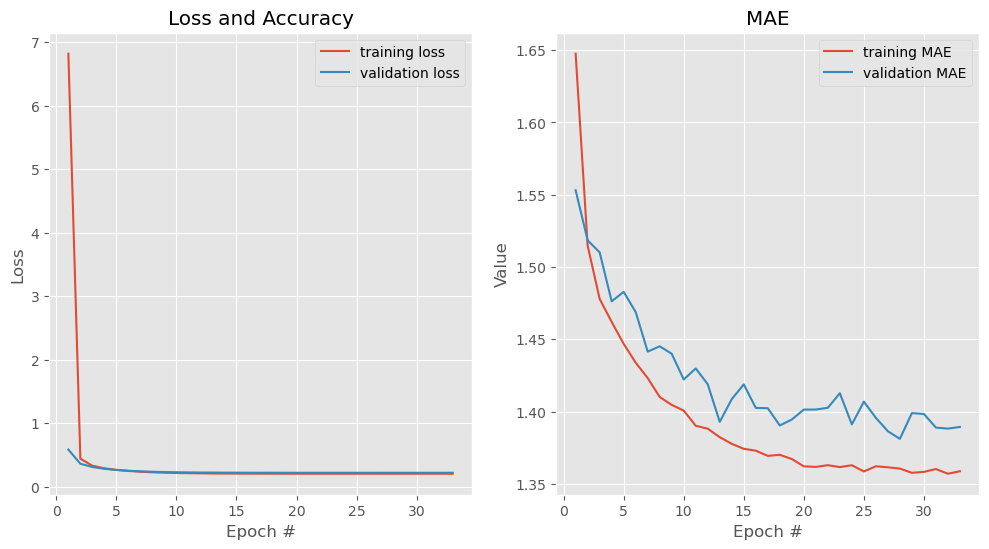

In [316]:
# Create a figure and two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Count number of epochs
epochs = len(history.history['loss'])

# Plot the loss and accuracy through training
ax1.plot(range(1, epochs + 1), history.history['loss'], label='training loss')
ax1.plot(range(1, epochs + 1), history.history['val_loss'], label='validation loss')
ax1.set_title('Loss and Accuracy')
ax1.set_xlabel('Epoch #')
ax1.set_ylabel('Loss')
ax1.legend()

# Plot MAE and RMAE
ax2.plot(range(1, epochs + 1), history.history['mean_absolute_error'], label='training MAE')
ax2.plot(range(1, epochs + 1), history.history['val_mean_absolute_error'], label='validation MAE')
# ax2.plot(range(1, maxEpoch + 1), history.history['rmae'], label='RMAE (Validation)')
# ax2.plot(range(1, maxEpoch + 1), history.history['train_rmae'], label='RMAE (Training)')
ax2.set_title('MAE')
ax2.set_xlabel('Epoch #')
ax2.set_ylabel('Value')
ax2.legend()

# Display the plot
plt.show()

As expected, the logarithmic loss function is not ideal, but it was expected so let's not waste too much time on it. 

### Weight Initialization

Let's try experimenting with weight initialization. For this purpose, we're gonna use the `kernal_initializer` parameters in our dense layers. We're gonna apply some of the most common initializations, which are `glorot_uniform`, `he_normal`, and `lecun_normal`.

#### Glorot Uniform

In [349]:
# Declare initializer
initialization = 'glorot_uniform'

# Declare l1 and l2 values
l1 = 0.0
l2 = 0.1
    
# Create a feedforward neural net
model = Sequential()

# Create the layers
model.add(Dense(256, activation=LeakyReLU(alpha=0.1), input_shape=(143,), kernel_regularizer = l1_l2(l1=l1, l2=l2), kernel_initializer=initialization))
model.add(Dropout(0.5))
model.add(Dense(128, activation=LeakyReLU(alpha=0.1), kernel_regularizer = l1_l2(l1=l1, l2=l2), kernel_initializer=initialization))
model.add(Dropout(0.4))
model.add(Dense(64, activation=LeakyReLU(alpha=0.1), kernel_regularizer = l1_l2(l1=l1, l2=l2), kernel_initializer=initialization))
model.add(Dropout(0.3))
model.add(Dense(32, activation=LeakyReLU(alpha=0.1), kernel_regularizer = l1_l2(l1=l1, l2=l2), kernel_initializer=initialization))
model.add(Dropout(0.1))
model.add(Dense(16, activation=LeakyReLU(alpha=0.1), kernel_regularizer = l1_l2(l1=l1, l2=l2), kernel_initializer=initialization))
model.add(Dropout(0.1))
model.add(Dense(8, activation=LeakyReLU(alpha=0.1), kernel_regularizer = l1_l2(l1=l1, l2=l2), kernel_initializer=initialization))
model.add(Dropout(0.1))
model.add(Dense(1, activation='linear', kernel_regularizer = l1_l2(l1=l1, l2=l2)))

# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_absolute_error'])

# Train the model
maxEpoch = 100
history = model.fit(trainX, trainY, epochs=maxEpoch, batch_size=32, validation_data=(validX, validY), callbacks=[early_stopping])

# Evaluate the model on the test set
loss, mae = model.evaluate(testX, testY)
print(f"Mean Squared Error: {loss}")
print(f"Mean Absolute Error: {mae}")

# Make predictions
valid_predictions = model.predict(validX)

# Print r2 value
r2 = r2_score(testY, valid_predictions)
print(f"R-squared (R2): {r2}")

Epoch 1/100
427/427 [==============================] - 4s 5ms/step - loss: 20.1033 - mean_absolute_error: 1.5304 - val_loss: 5.9826 - val_mean_absolute_error: 1.2743
Epoch 2/100
427/427 [==============================] - 2s 4ms/step - loss: 4.8049 - mean_absolute_error: 1.3578 - val_loss: 3.7033 - val_mean_absolute_error: 1.2884
Epoch 3/100
427/427 [==============================] - 2s 4ms/step - loss: 3.8819 - mean_absolute_error: 1.3536 - val_loss: 3.6150 - val_mean_absolute_error: 1.3138
Epoch 4/100
427/427 [==============================] - 2s 4ms/step - loss: 3.6830 - mean_absolute_error: 1.3458 - val_loss: 3.3706 - val_mean_absolute_error: 1.2897
Epoch 5/100
427/427 [==============================] - 2s 5ms/step - loss: 3.6026 - mean_absolute_error: 1.3423 - val_loss: 3.3708 - val_mean_absolute_error: 1.3031
Epoch 6/100
427/427 [==============================] - 2s 4ms/step - loss: 3.5525 - mean_absolute_error: 1.3405 - val_loss: 3.3213 - val_mean_absolute_error: 1.2976
Epoch 7/1

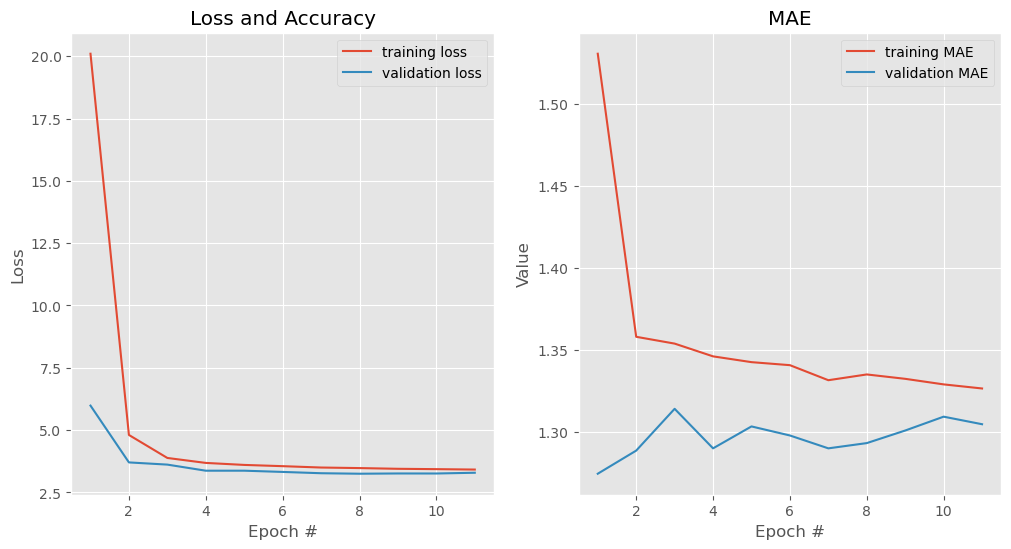

In [350]:
# Create a figure and two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Count number of epochs
epochs = len(history.history['loss'])

# Plot the loss and accuracy through training
ax1.plot(range(1, epochs + 1), history.history['loss'], label='training loss')
ax1.plot(range(1, epochs + 1), history.history['val_loss'], label='validation loss')
ax1.set_title('Loss and Accuracy')
ax1.set_xlabel('Epoch #')
ax1.set_ylabel('Loss')
ax1.legend()

# Plot MAE and RMAE
ax2.plot(range(1, epochs + 1), history.history['mean_absolute_error'], label='training MAE')
ax2.plot(range(1, epochs + 1), history.history['val_mean_absolute_error'], label='validation MAE')
# ax2.plot(range(1, maxEpoch + 1), history.history['rmae'], label='RMAE (Validation)')
# ax2.plot(range(1, maxEpoch + 1), history.history['train_rmae'], label='RMAE (Training)')
ax2.set_title('MAE')
ax2.set_xlabel('Epoch #')
ax2.set_ylabel('Value')
ax2.legend()

# Display the plot
plt.show()

#### He Normal

In [351]:
# Declare initializer
initialization = 'he_normal'

# Declare l1 and l2 values
l1 = 0.0
l2 = 0.1
    
# Create a feedforward neural net
model = Sequential()

# Create the layers
model.add(Dense(256, activation=LeakyReLU(alpha=0.1), input_shape=(143,), kernel_regularizer = l1_l2(l1=l1, l2=l2), kernel_initializer=initialization))
model.add(Dropout(0.5))
model.add(Dense(128, activation=LeakyReLU(alpha=0.1), kernel_regularizer = l1_l2(l1=l1, l2=l2), kernel_initializer=initialization))
model.add(Dropout(0.4))
model.add(Dense(64, activation=LeakyReLU(alpha=0.1), kernel_regularizer = l1_l2(l1=l1, l2=l2), kernel_initializer=initialization))
model.add(Dropout(0.3))
model.add(Dense(32, activation=LeakyReLU(alpha=0.1), kernel_regularizer = l1_l2(l1=l1, l2=l2), kernel_initializer=initialization))
model.add(Dropout(0.1))
model.add(Dense(16, activation=LeakyReLU(alpha=0.1), kernel_regularizer = l1_l2(l1=l1, l2=l2), kernel_initializer=initialization))
model.add(Dropout(0.1))
model.add(Dense(8, activation=LeakyReLU(alpha=0.1), kernel_regularizer = l1_l2(l1=l1, l2=l2), kernel_initializer=initialization))
model.add(Dropout(0.1))
model.add(Dense(1, activation='linear', kernel_regularizer = l1_l2(l1=l1, l2=l2)))

# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_absolute_error'])

# Train the model
maxEpoch = 100
history = model.fit(trainX, trainY, epochs=maxEpoch, batch_size=32, validation_data=(validX, validY), callbacks=[early_stopping])

# Evaluate the model on the test set
loss, mae = model.evaluate(testX, testY)
print(f"Mean Squared Error: {loss}")
print(f"Mean Absolute Error: {mae}")

# Make predictions
valid_predictions = model.predict(validX)

# Print r2 value
r2 = r2_score(testY, valid_predictions)
print(f"R-squared (R2): {r2}")

Epoch 1/100
427/427 [==============================] - 4s 5ms/step - loss: 65.5514 - mean_absolute_error: 1.7238 - val_loss: 33.6707 - val_mean_absolute_error: 1.3502
Epoch 2/100
427/427 [==============================] - 2s 4ms/step - loss: 20.4427 - mean_absolute_error: 1.3719 - val_loss: 11.6843 - val_mean_absolute_error: 1.2858
Epoch 3/100
427/427 [==============================] - 2s 4ms/step - loss: 8.7139 - mean_absolute_error: 1.3231 - val_loss: 6.4021 - val_mean_absolute_error: 1.2685
Epoch 4/100
427/427 [==============================] - 2s 5ms/step - loss: 5.6167 - mean_absolute_error: 1.3196 - val_loss: 4.7130 - val_mean_absolute_error: 1.2812
Epoch 5/100
427/427 [==============================] - 2s 4ms/step - loss: 4.5031 - mean_absolute_error: 1.3183 - val_loss: 3.9620 - val_mean_absolute_error: 1.2788
Epoch 6/100
427/427 [==============================] - 2s 4ms/step - loss: 3.9886 - mean_absolute_error: 1.3179 - val_loss: 3.6590 - val_mean_absolute_error: 1.2904
Epoch 

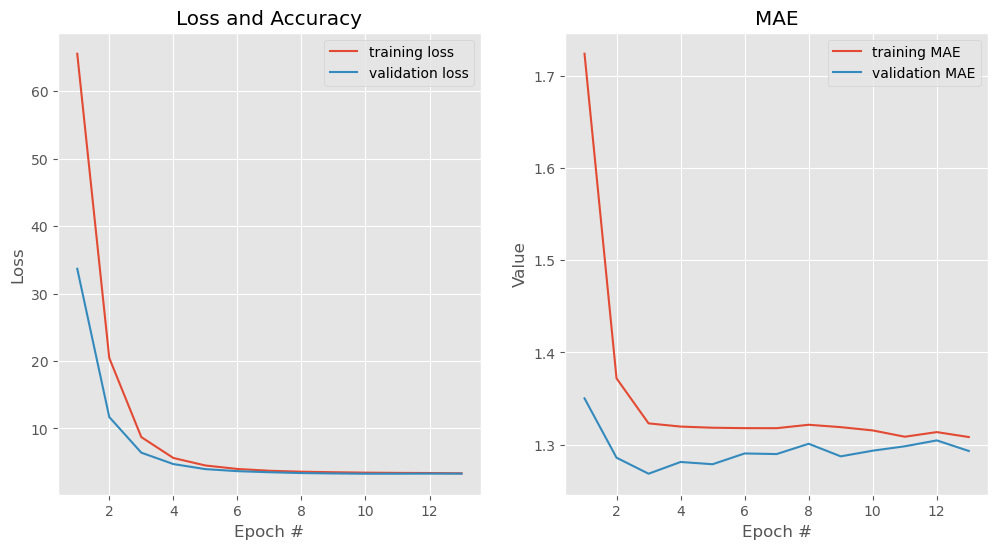

In [352]:
# Create a figure and two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Count number of epochs
epochs = len(history.history['loss'])

# Plot the loss and accuracy through training
ax1.plot(range(1, epochs + 1), history.history['loss'], label='training loss')
ax1.plot(range(1, epochs + 1), history.history['val_loss'], label='validation loss')
ax1.set_title('Loss and Accuracy')
ax1.set_xlabel('Epoch #')
ax1.set_ylabel('Loss')
ax1.legend()

# Plot MAE and RMAE
ax2.plot(range(1, epochs + 1), history.history['mean_absolute_error'], label='training MAE')
ax2.plot(range(1, epochs + 1), history.history['val_mean_absolute_error'], label='validation MAE')
# ax2.plot(range(1, maxEpoch + 1), history.history['rmae'], label='RMAE (Validation)')
# ax2.plot(range(1, maxEpoch + 1), history.history['train_rmae'], label='RMAE (Training)')
ax2.set_title('MAE')
ax2.set_xlabel('Epoch #')
ax2.set_ylabel('Value')
ax2.legend()

# Display the plot
plt.show()

#### Lecun Normal

In [353]:
# Declare initializer
initialization = 'lecun_normal'

# Declare l1 and l2 values
l1 = 0.0
l2 = 0.1
    
# Create a feedforward neural net
model = Sequential()

# Create the layers
model.add(Dense(256, activation=LeakyReLU(alpha=0.1), input_shape=(143,), kernel_regularizer = l1_l2(l1=l1, l2=l2), kernel_initializer=initialization))
model.add(Dropout(0.5))
model.add(Dense(128, activation=LeakyReLU(alpha=0.1), kernel_regularizer = l1_l2(l1=l1, l2=l2), kernel_initializer=initialization))
model.add(Dropout(0.4))
model.add(Dense(64, activation=LeakyReLU(alpha=0.1), kernel_regularizer = l1_l2(l1=l1, l2=l2), kernel_initializer=initialization))
model.add(Dropout(0.3))
model.add(Dense(32, activation=LeakyReLU(alpha=0.1), kernel_regularizer = l1_l2(l1=l1, l2=l2), kernel_initializer=initialization))
model.add(Dropout(0.1))
model.add(Dense(16, activation=LeakyReLU(alpha=0.1), kernel_regularizer = l1_l2(l1=l1, l2=l2), kernel_initializer=initialization))
model.add(Dropout(0.1))
model.add(Dense(8, activation=LeakyReLU(alpha=0.1), kernel_regularizer = l1_l2(l1=l1, l2=l2), kernel_initializer=initialization))
model.add(Dropout(0.1))
model.add(Dense(1, activation='linear', kernel_regularizer = l1_l2(l1=l1, l2=l2)))

# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_absolute_error'])

# Train the model
maxEpoch = 100
history = model.fit(trainX, trainY, epochs=maxEpoch, batch_size=32, validation_data=(validX, validY), callbacks=[early_stopping])

# Evaluate the model on the test set
loss, mae = model.evaluate(testX, testY)
print(f"Mean Squared Error: {loss}")
print(f"Mean Absolute Error: {mae}")

# Make predictions
valid_predictions = model.predict(validX)

# Print r2 value
r2 = r2_score(testY, valid_predictions)
print(f"R-squared (R2): {r2}")

Epoch 1/100
427/427 [==============================] - 4s 6ms/step - loss: 17.4302 - mean_absolute_error: 1.6162 - val_loss: 5.4190 - val_mean_absolute_error: 1.2901
Epoch 2/100
427/427 [==============================] - 2s 5ms/step - loss: 4.7674 - mean_absolute_error: 1.3842 - val_loss: 3.7261 - val_mean_absolute_error: 1.2782
Epoch 3/100
427/427 [==============================] - 2s 4ms/step - loss: 3.9736 - mean_absolute_error: 1.3612 - val_loss: 3.5531 - val_mean_absolute_error: 1.2930
Epoch 4/100
427/427 [==============================] - 2s 4ms/step - loss: 3.7315 - mean_absolute_error: 1.3502 - val_loss: 3.3765 - val_mean_absolute_error: 1.2969
Epoch 5/100
427/427 [==============================] - 2s 4ms/step - loss: 3.6278 - mean_absolute_error: 1.3510 - val_loss: 3.3405 - val_mean_absolute_error: 1.3077
Epoch 6/100
427/427 [==============================] - 2s 4ms/step - loss: 3.5391 - mean_absolute_error: 1.3431 - val_loss: 3.3181 - val_mean_absolute_error: 1.2967
Epoch 7/1

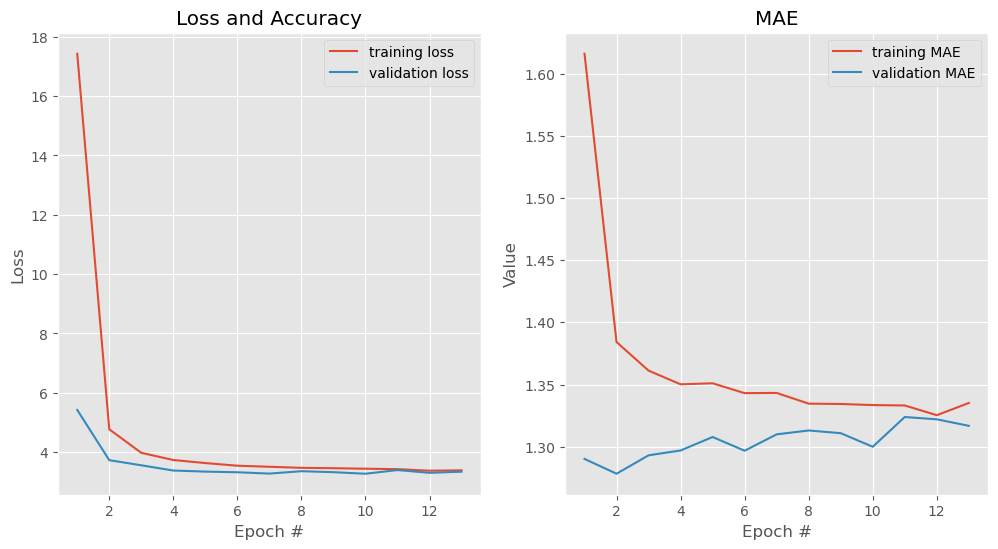

In [354]:
# Create a figure and two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Count number of epochs
epochs = len(history.history['loss'])

# Plot the loss and accuracy through training
ax1.plot(range(1, epochs + 1), history.history['loss'], label='training loss')
ax1.plot(range(1, epochs + 1), history.history['val_loss'], label='validation loss')
ax1.set_title('Loss and Accuracy')
ax1.set_xlabel('Epoch #')
ax1.set_ylabel('Loss')
ax1.legend()

# Plot MAE and RMAE
ax2.plot(range(1, epochs + 1), history.history['mean_absolute_error'], label='training MAE')
ax2.plot(range(1, epochs + 1), history.history['val_mean_absolute_error'], label='validation MAE')
# ax2.plot(range(1, maxEpoch + 1), history.history['rmae'], label='RMAE (Validation)')
# ax2.plot(range(1, maxEpoch + 1), history.history['train_rmae'], label='RMAE (Training)')
ax2.set_title('MAE')
ax2.set_xlabel('Epoch #')
ax2.set_ylabel('Value')
ax2.legend()

# Display the plot
plt.show()

Evaluating all these models, we see that that none of them helped significantly with our R2 value, however, they all remained well within the boundaries for overfitting so that is a plus. This is as far as our analysis will go, as we have explored various hyperparameters and seen little to no change. 

## Conclusions

In conclusion, we found that a more dense model provided the best results in terms of R2 value, while minimizing our losses and errors. Within our model we found that a LeakyReLU activation served best along with a mean squared error loss function. We also found a lot of success with preventing overfitting by aggressively applying regularization.

On of the major flaws in our model was the consistent underfitting that occured throughout our analysis. This was visible through the persistence of a negative R2 value, indicating that the model was doing a very good job of predicting the actual values, as we were looking to get as close to an R2 value of 1 as possible. 

Given more time, I would have liked to explore additional card characteristics as input which may provide more insight into the underlying trends in Magic the Gathering card costs. This could include card specific characteristics such as the power and toughness of creatures, which tend to increase as the cost of the card increases. This could have greatly helped prevent the underfitting that we observed simply by providing more data for the model to learn from.

Finally, one more method that could have lead to a more succesful model would have been to further increase the complexity of the model. By adding in more layers and changing the layer types, it may have been possible to overcome the underfitting and actually produce worthwhile results and a model that could contribute to our understanding of the fundamental principles of the card game. Such an endevor would require a complete recallibration of the the hyperparameters, and it might even be viable to explore automatic methods for parameter tuning in the future. 